In [118]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [119]:
training_data = pd.read_csv('../dataset/usage_train.csv', date_parser = pd.to_datetime)
test_data = pd.read_csv('../dataset/usage_test.csv',date_parser = pd.to_datetime)

### Explore the data

In [120]:
print(training_data.shape)
print(test_data.shape)

(171840, 3)
(3360, 2)


In [121]:
training_data.head(5)

,id,datetime,usage
0,MAC003828,2012-12-17 09:00:00,0.073
1,MAC003828,2012-12-17 09:30:00,0.054
2,MAC003828,2012-12-17 10:00:00,0.069
3,MAC003828,2012-12-17 10:30:00,0.070
4,MAC003828,2012-12-17 11:00:00,0.049


In [122]:
test_data.head(5)

,id,datetime
0,MAC003828,2013-12-10 09:00:00
1,MAC003828,2013-12-10 09:30:00
2,MAC003828,2013-12-10 10:00:00
3,MAC003828,2013-12-10 10:30:00
4,MAC003828,2013-12-10 11:00:00


In [123]:
print(training_data.id.nunique())
ids_training = training_data.id.unique().tolist()

10


In [124]:
print(test_data.id.nunique())
ids_test = test_data.id.unique().tolist()

10


Confirm that we have the same ids in both datasets

In [125]:
set(ids_training).difference(set(ids_test))

set()

In [126]:
set(ids_test).difference(set(ids_training))

set()

In [127]:
training_data.groupby(['id']).agg({'datetime': [np.max, np.min]})

datetime                     
                          amax                 amin
id                                                 
MAC000085  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC000094  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC000246  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC001757  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC003685  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC003828  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC004166  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC004218  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC004671  2013-12-10 08:30:00  2012-12-17 09:00:00
MAC005415  2013-12-10 08:30:00  2012-12-17 09:00:00

In [128]:
training_data.groupby(['id'])['datetime'].count()

id
MAC000085    17184
MAC000094    17184
MAC000246    17184
MAC001757    17184
MAC003685    17184
MAC003828    17184
MAC004166    17184
MAC004218    17184
MAC004671    17184
MAC005415    17184
Name: datetime, dtype: int64

In [129]:
training_data.groupby(['id']).describe()

usage                                                         
             count      mean       std    min    25%    50%      75%    max
id                                                                         
MAC000085  17184.0  0.540606  0.493135  0.075  0.153  0.355  0.78500  3.610
MAC000094  17184.0  0.243749  0.202284  0.084  0.124  0.162  0.29325  1.997
MAC000246  17184.0  0.394186  0.471587  0.014  0.076  0.187  0.56900  3.516
MAC001757  17184.0  0.145882  0.083797  0.023  0.087  0.126  0.18600  1.038
MAC003685  17184.0  0.243834  0.262984  0.045  0.097  0.138  0.29900  2.243
MAC003828  17184.0  0.215379  0.233891  0.030  0.089  0.126  0.23700  2.814
MAC004166  17184.0  0.133510  0.149090  0.027  0.057  0.085  0.14400  2.020
MAC004218  17184.0  0.262127  0.311265  0.083  0.113  0.126  0.20400  3.387
MAC004671  17184.0  0.407434  0.327176  0.078  0.219  0.272  0.44200  3.340
MAC005415  17184.0  0.070247  0.044182  0.009  0.041  0.061  0.09000  0.561

**Obs**: we have spikes in the data, no zero value measurements (good!)

In [130]:
training_data.isnull().values.any()

False

In [131]:
test_data.groupby(['id']).agg({'datetime': [np.max, np.min]})

datetime                     
                          amax                 amin
id                                                 
MAC000085  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC000094  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC000246  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC001757  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC003685  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC003828  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC004166  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC004218  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC004671  2013-12-17 08:30:00  2013-12-10 09:00:00
MAC005415  2013-12-17 08:30:00  2013-12-10 09:00:00

In [132]:
test_data.groupby(['id'])['datetime'].count()

id
MAC000085    336
MAC000094    336
MAC000246    336
MAC001757    336
MAC003685    336
MAC003828    336
MAC004166    336
MAC004218    336
MAC004671    336
MAC005415    336
Name: datetime, dtype: int64

In [133]:
print(training_data[training_data['datetime'].isnull()])
print(training_data[training_data['usage'].isnull()])

Empty DataFrame
Columns: [id, datetime, usage]
Index: []
Empty DataFrame
Columns: [id, datetime, usage]
Index: []


**Obs:** 
No missing values and all measurements for the same time period

#### Transform the datetime

In [134]:
for df in [training_data, test_data]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    df['year'] = df.datetime.apply(lambda x: x.year)
    df['month'] = df.datetime.apply(lambda x: x.month)
    df['day'] = df.datetime.apply(lambda x: x.day)
    df['dayofWeek'] = df.datetime.apply(lambda x: x.dayofweek)
    df['weekOfYear'] = df.datetime.apply(lambda x: x.weekofyear)

### Visualise the data

In [140]:
size_week = 2*24*7 #(2 samples a hour)

In [145]:
def plot_for_weeks(df, size_week, number_weeks):
    # TODO: have to do shared y axis... they all have different scales
    
    for house_id, pos in zip(df.id.unique(), range(0,df.id.nunique(), 1)):
        plt.figure(figsize=(20, 30))
        a = plt.subplot(df.id.nunique(),1,pos+1)
        aux = df[df.id == house_id]
        aux.sort_values('datetime')
        plt.plot(aux.datetime[:number_weeks*size_week], aux.usage[:number_weeks*size_week])
        plt.title('House {}'.format(house_id))

        locs, labels = plt.xticks()
        x = list(range(0, len(locs), size_week))
        new_locs = [locs[i] for i in x]
        new_labels = [labels[i] for i in x]
        if pos != training_data.id.nunique()-1:
            plt.setp(a.get_xticklabels(), visible=False)
        plt.xticks(new_locs, rotation='vertical')
        plt.show()

#### Visualise the first 2 weeks

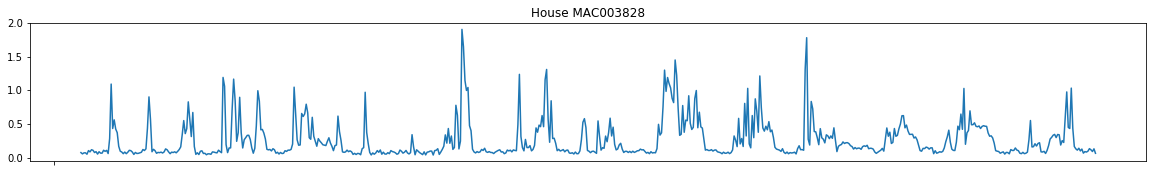

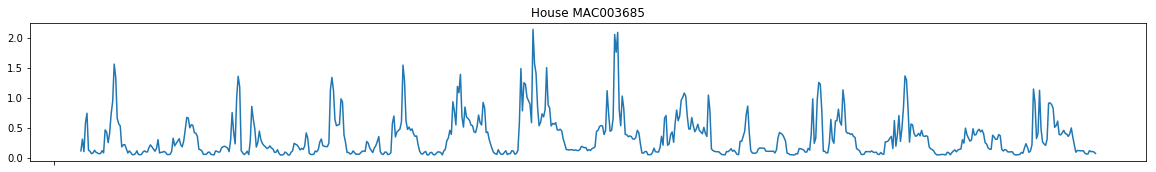

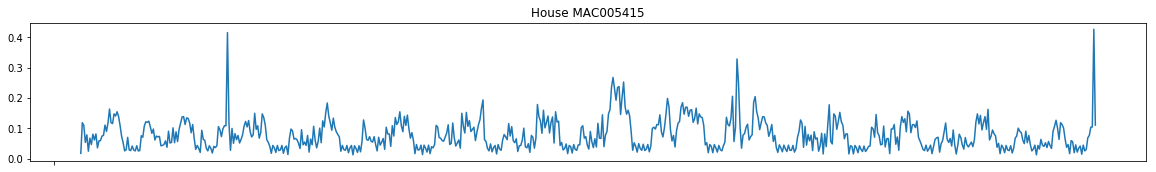

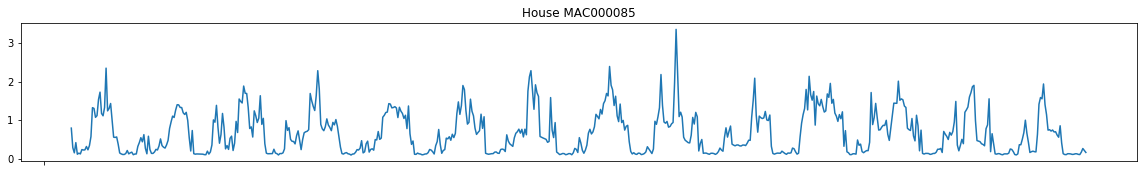

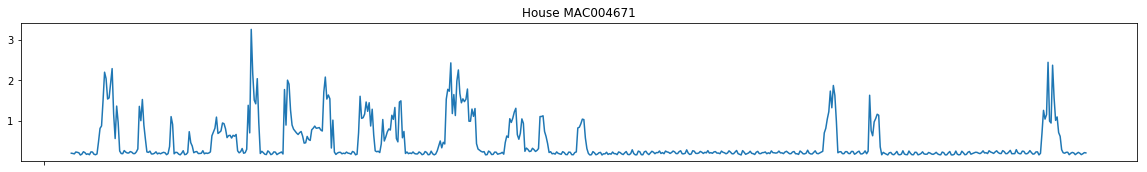

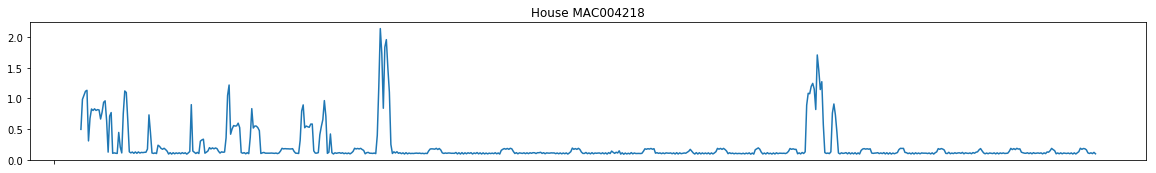

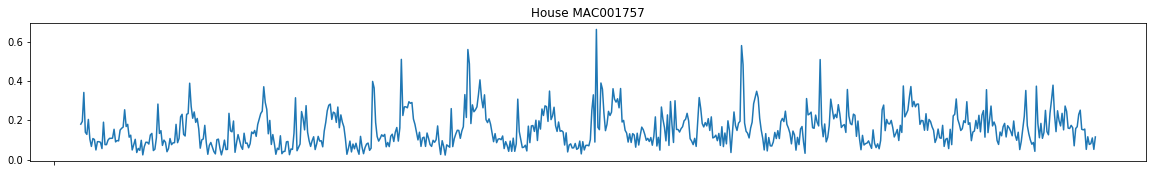

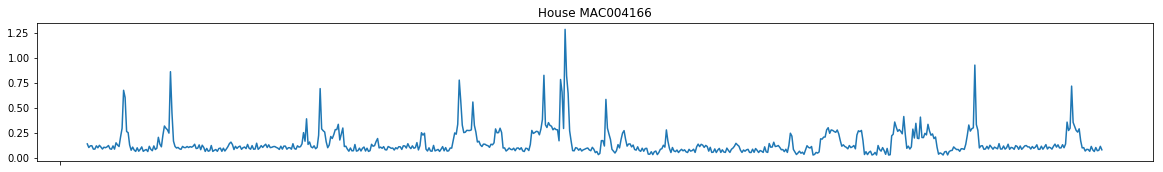

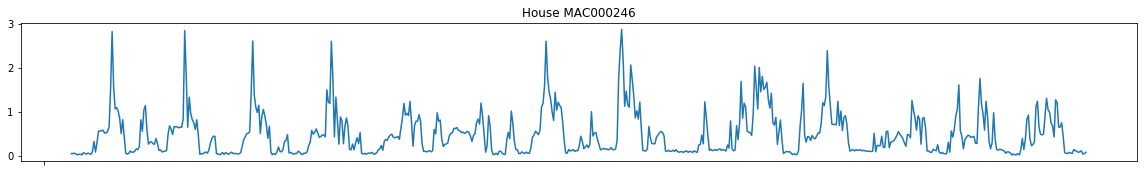

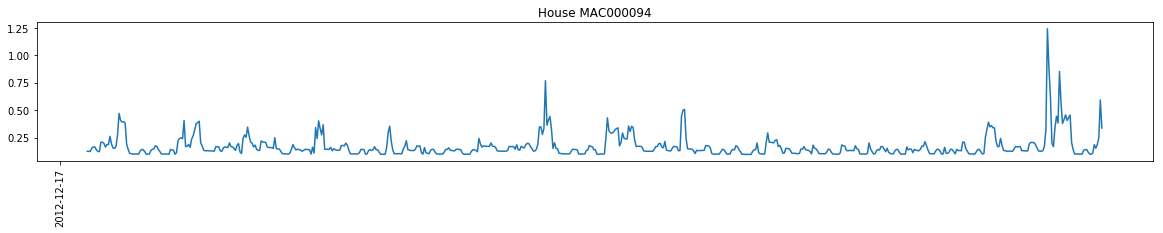

In [146]:
plot_for_weeks(training_data, size_week, 2)

**Obs:**
- for most of the houses there is a daily seasonality, and weekends.
- some houses have periods of low consumption (holidays?)

#### Visualise the first 15 weeks

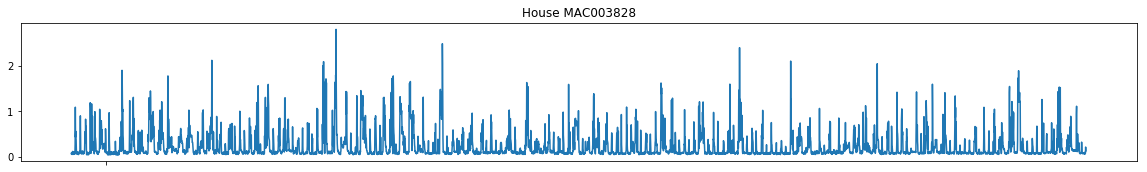

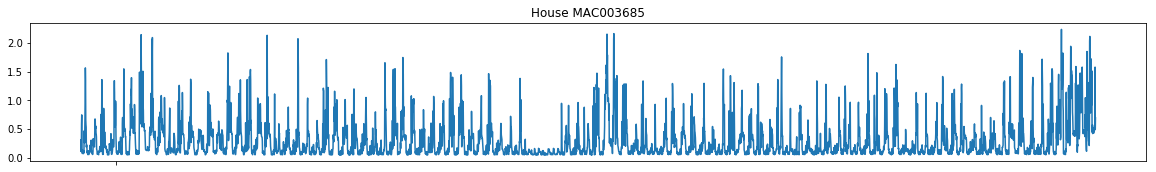

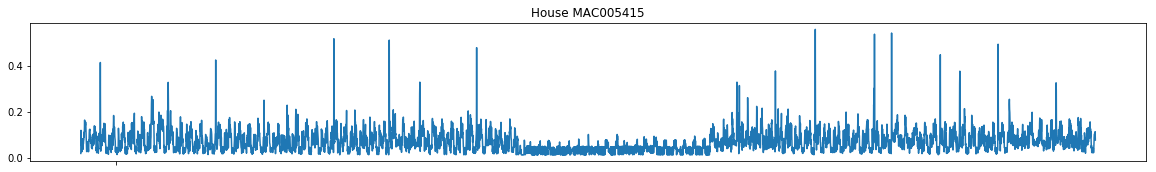

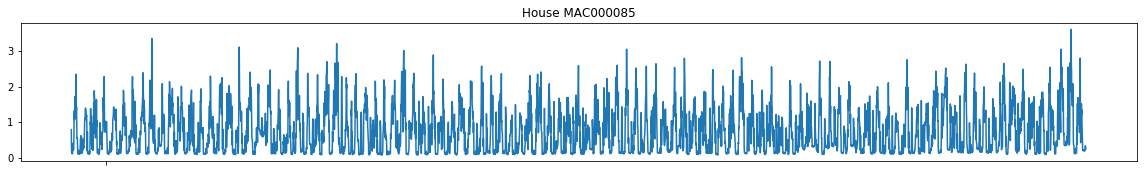

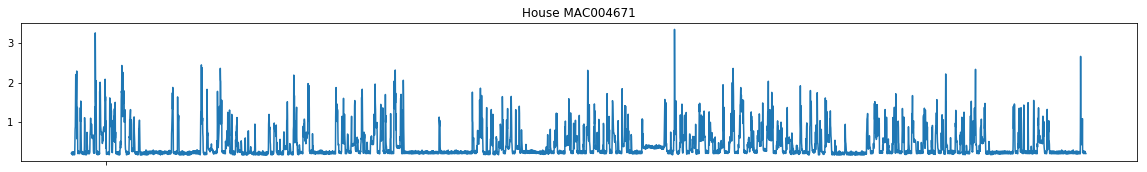

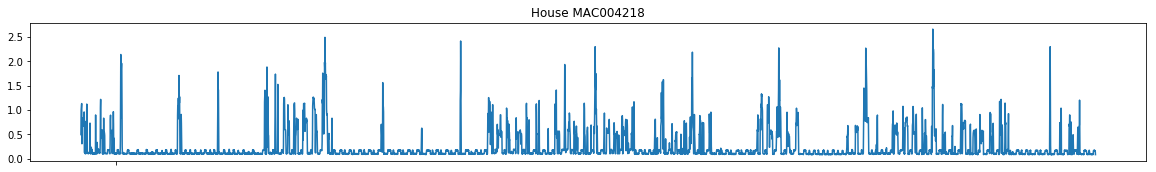

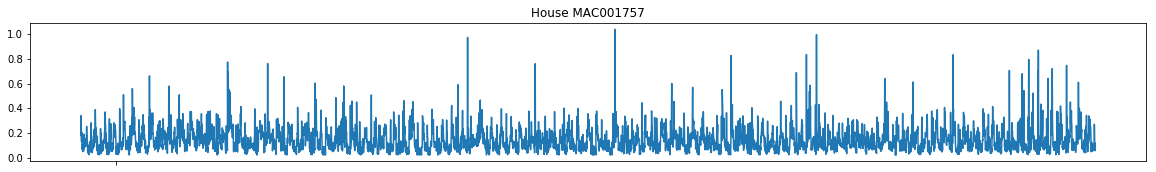

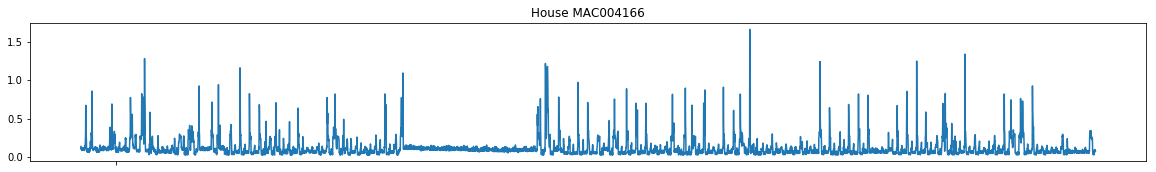

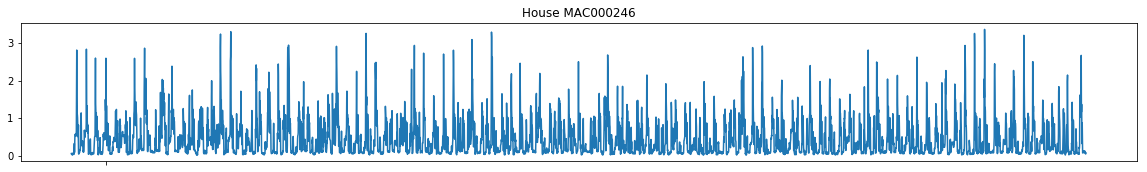

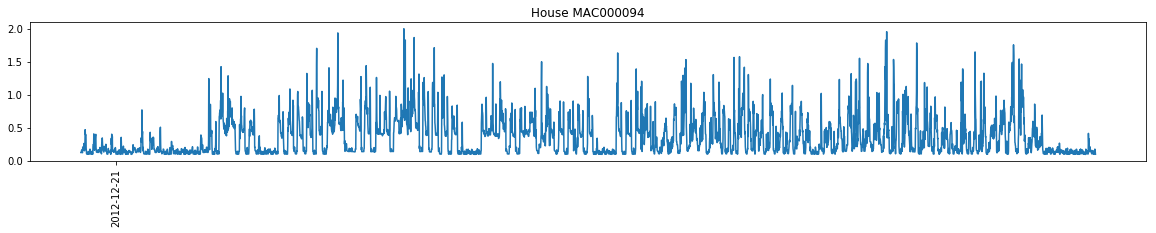

In [147]:
plot_for_weeks(training_data, size_week, 15)

**Obs:**

it feels that we have 2 types of behaviours:

    --constant consumption, with just 1 or 2 windows of low consumption
    --houses with cycle periods of low consumption (MAC004218, MAC004671, MAC000094)


### Explore seasonality and trend

given that the test file doesn't have the true value, I'm going to split the training dataset again. I'll consider the last 0.33 as test set before I continue

In [69]:
n_index = training_data.datetime.nunique()
idx_split = math.floor(n_index*0.66)
list_dates = list(training_data.datetime.unique())
threshold = list_dates[idx_split]
print(list_dates[idx_split])

2013-08-10T15:30:00.000000000


In [149]:
df_training = training_data[training_data.datetime < threshold]
df_test = training_data[training_data.datetime >= threshold]

I'm going to assume an additive model to search for the model

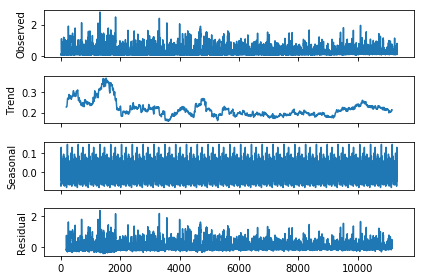

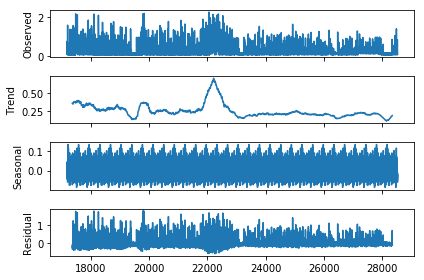

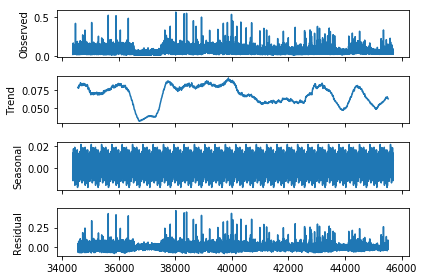

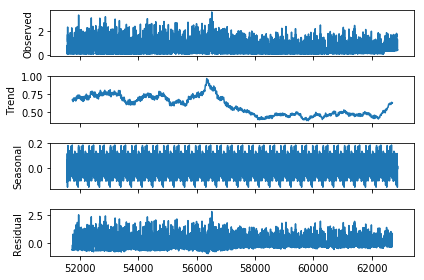

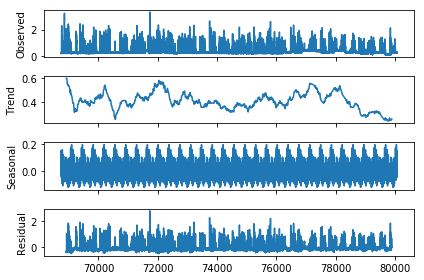

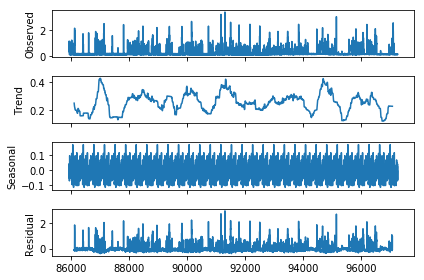

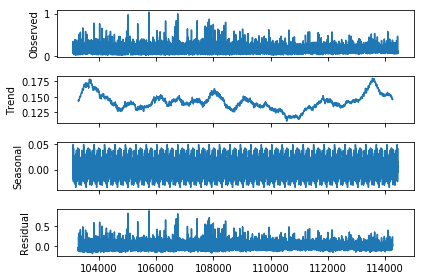

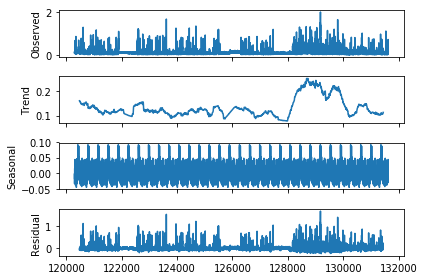

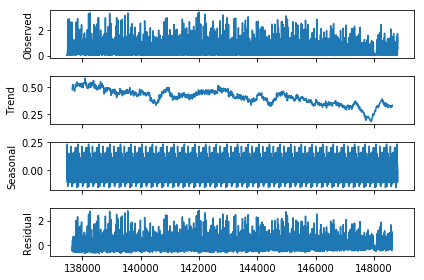

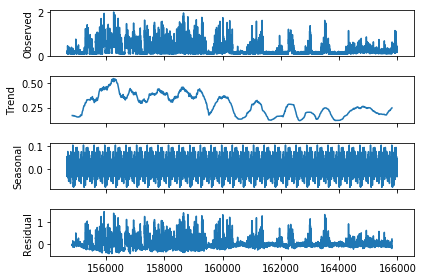

In [157]:
for house_id in df_training.id.unique():
#     print('House {}'.format(house_id))
    ts_for_house = df_training[df_training.id == house_id]
    result = seasonal_decompose(
        ts_for_house.usage,
        model='additive',
        freq = 365,
    )
    result.plot()

**Obs**:

Some houses have a decrease once we get into the 'hot months'.

There is a house that start to have heighter consumption on those months

#### Look at the autocorrelation values

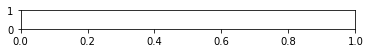

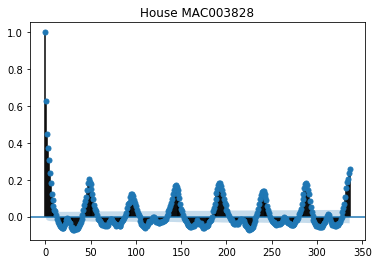

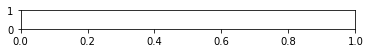

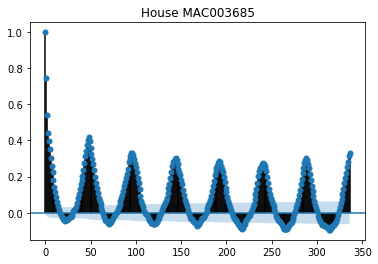

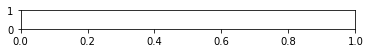

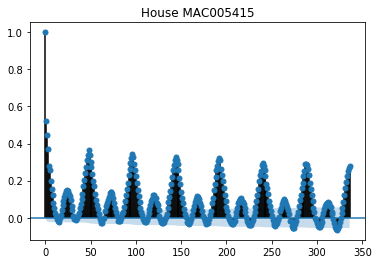

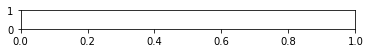

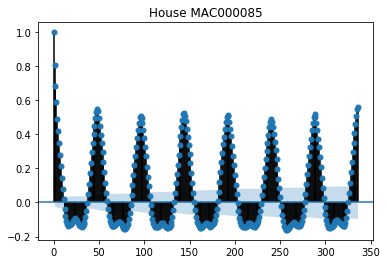

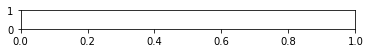

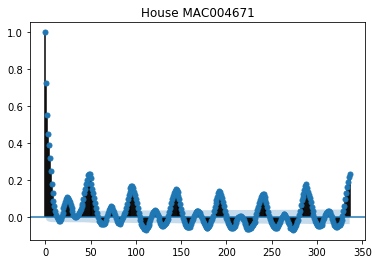

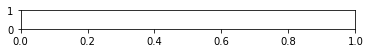

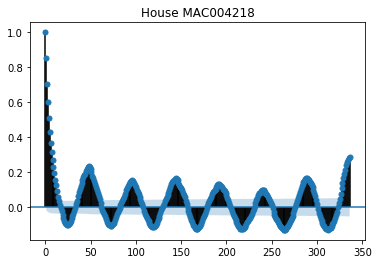

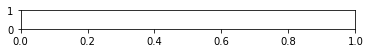

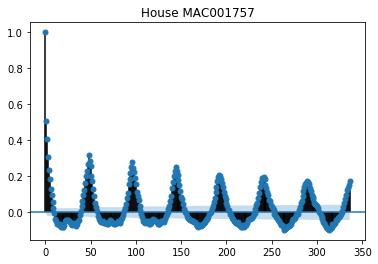

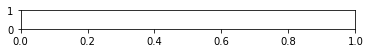

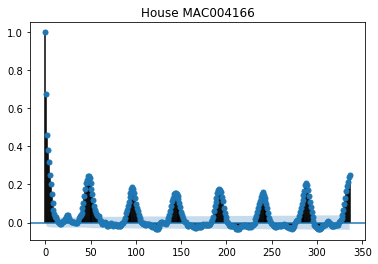

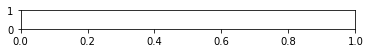

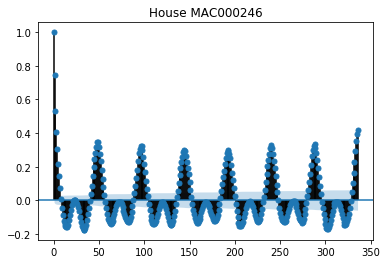

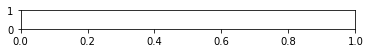

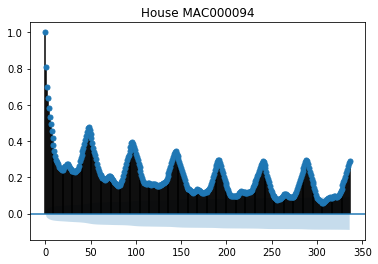

In [155]:
# have to do shared y axis... they all have different scales

for house_id, pos in zip(training_data.id.unique(), range(0,training_data.id.nunique(), 1)):

    a = plt.subplot(training_data.id.nunique(),1,pos+1)
    aux = training_data[training_data.id == house_id]
    aux.sort_values('datetime')
    x = plot_acf(aux.usage, lags = size_week)
    plt.title('House {}'.format(house_id))
    plt.show()
    

** Obs:** 

    - We can see a daily pattern that decreases along the week.
    - Again, it feels like two times of consumption:
        -- houses MAC000085, MAC004218 and MAC000094 have autocorrelation values higher than 0.4 up to lag 5.
        -- the remaining houses have autocorrelation values higher than 0.4 just up to lag 1 or 2
    - MAC00085 has a lot of correlation within the time series (daily seasonality). It's the only house that doesn't have periods of low consumption during the first 15weeks.
    - I'm just looking within the week. It's missing to verify if there is monthly autocorrelation as well.
    - If we change from lags= size_week to lags = 2*size_week we see a spike in most of the houses that would corresponde to the begining of the second week, suggesting that we have also a weekly relation between values.
